# Figure 1: Reconstruction error

This documents the error that creeps in as a result of our representation of the cell as a spiral or level set or reduced resolution segmentation. We will encode all the cells in our dataset using these methods at differing resolutions and see how well/poorly they fit the original cells.

## Standard imports

In [1]:
# System installed
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# System or local
import celloutline

Set the locations of our cell dataset.

In [2]:
datapath = os.path.join(celloutline.__path__[0], 'data/cell_segs.npz')
cell_segs = np.load(datapath)
cell_names = cell_segs.keys()

## Profiling run time

To get a sense of how long things will take to run and thus where to run them, let's profile the encodings.

In [3]:
bvox = celloutline.representation.BinaryVoxel(cell_names[0], cell_segs)

In [9]:
%timeit celloutline.conversions.binary_to_trimesh(bvox.voxels)

10 loops, best of 3: 54.1 ms per loop


In [10]:
%timeit celloutline.conversions.binary_to_spiral(bvox.voxels)

1 loop, best of 3: 10.9 s per loop


In [11]:
#Like above but without recomputing spiral
spiral = celloutline.geom.UnitSpiral(500)
%timeit celloutline.conversions.binary_to_spiral(bvox.voxels, spiral)

1 loop, best of 3: 8.75 s per loop


In [12]:
%timeit celloutline.conversions.binary_to_spread(bvox.voxels)

1 loop, best of 3: 420 ms per loop


## Functionalizing 
So it looks like binary to mesh is fine and so is binary to spread, it is just the spiral conversion that takes some time. Let's create a function to output the errors we want:

- marching cube step down 1x
- marching cube step down 2x
- marching cube step down 3x
- spiral with 100 pts
- spiral with 200 pts
- spiral with 500 pts
- spiral with 1000 pts
- spiral with 2000 pts
- spread

First we'll pre-calculate all our unit spirals to save time:

In [4]:
# This takes a bit for longer spirals
#spirals = {n:celloutline.geom.UnitSpiral(n) for n in [100,200,500,1000,2000]} # for reals
spirals = {n:celloutline.geom.UnitSpiral(n) for n in [100,200,500]} # for testing

In [5]:
def reconerrors(indict):
    """Reconstruction errors compared to the marching cubes mesh
    of the segmentation. See unpacking below for what indict should have
    """
    ## Unpack the input dict
    name = indict['name']
    segmentation = indict['segmentation']
    unitspirals = indict['spirals']
    ## Set up meshes
    cube1 = celloutline.conversions.binary_to_trimesh(segmentation, 1)
    cube2 = celloutline.conversions.binary_to_trimesh(segmentation, 2)
    cube3 = celloutline.conversions.binary_to_trimesh(segmentation, 3)
    spirals = {}
    for n, spiral in unitspirals.items():
        spiral_dict = celloutline.conversions.binary_to_spiral(segmentation, spiral)
        spiral_mesh = celloutline.conversions.spiral_to_trimesh(**spiral_dict)
        spirals[n] = spiral_mesh
    spread = celloutline.conversions.spread_to_trimesh(
        celloutline.conversions.binary_to_spread(segmentation), 0)
    ## Get mesh errors with type, res, error
    err = lambda mesh: celloutline.representation.mesh_error(cube1, mesh)
    errors = []
    errors.append({'type':'cube', 'res':1, 'error':err(cube1)})
    errors.append({'type':'cube', 'res':2, 'error':err(cube2)})
    errors.append({'type':'cube', 'res':3, 'error':err(cube3)})
    for n,smesh in spirals.items():
        errors.append({'type':'spiral', 'res':n, 'error':err(smesh)})
    errors.append({'type': 'spread', 'res':0, 'error':err(spread)})
    ## Add the cell name to each error dict
    for errordict in errors:
        errordict['name'] = name
    ## Pass the error dict back, ready to be loaded into a dataframe
    return errors

## Function on test data 

That is the function for calculating the reconstruction errors we want to show. We need to see how best to run it. First some test data:

In [6]:
test_dicts = []
for name in cell_names[:5]:
    test_dicts.append({'name':name,
                     'segmentation':cell_segs[name], 
                     'spirals':spirals})

In [7]:
test_out = [reconerrors(d) for d in test_dicts]

## Scaling up with multiprocessing

That looks like it will work, now let's do it for all entries. This next few cells are run on a high-core-count server. 

First create all the cell dictionaries to pass in.

In [ ]:
cell_dicts = [{'name': name, 'segmentation': cell_segs[name],  
               'spirals': spirals}  for name in cell_names]

Now the long running step:

In [80]:
import tqdm
import multiprocessing as mp
cpu_n = mp.cpu_count()
pool = mp.Pool(cpu_n-2)

error_dicts = []
chunk_size = 1
with tqdm.tqdm_notebook(total=len(cell_dicts)/cs) as pbar:
    for rerr in pool.imap_unordered(reconerrors, cell_dicts, chunk_size):
        error_dicts.append(rerr)
        pbar.update()

And save the output to disk for figure creation back on a local laptop

In [3]:
out_fn = './figure_1_representation_error.csv'
header = True
if not os.path.exists(out_fn): #don't overwrite the file if present
    for cell in error_dicts:
        df = pd.DataFrame(cell)
        df.to_csv(out_fn, 
                  float_format="%0.5f", 
                  index=False, 
                  header=header, 
                  mode='a+')
        header=False

## Plotting

Now that we have all the data we want, let's create the figure from it.

In [4]:
df = pd.read_csv(out_fn, names=['error', 'name', 'res', 'type'])
print(df.shape)
df.head(2)

(136521, 4)


,error,name,res,type
0,1.00000,3500000468_100X_20170124_E07_P15.czi_1.npz,1,cube
1,0.89536,3500000468_100X_20170124_E07_P15.czi_1.npz,2,cube


In [10]:
df.describe()

,error,res
count,136521.000000,136521.000000
mean,0.887290,422.888889
std,0.583657,640.358053
min,-155.594840,0.000000
25%,0.846340,2.000000
50%,0.886060,100.000000
75%,0.925260,500.000000
max,118.524660,2000.000000


We throw out the wacky errors, those above or below the 99.9th percentile or below the .1th percentile. 

In [21]:
lowcutoff, highcutoff = df.error.quantile(.001), df.error.quantile(.999)
print("Cutoffs are below %0.2f or above %0.2f"%(lowcutoff, highcutoff))

df = df.where(np.logical_and(df.error>lowcutoff, df.error<highcutoff))

Cutoffs are below 0.55 or above 1.28


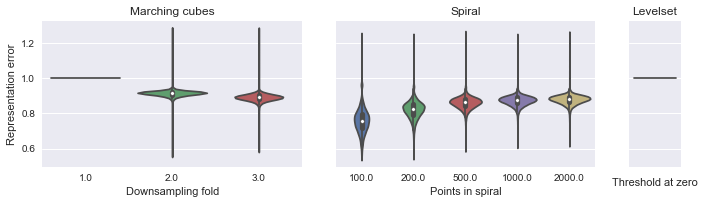

In [27]:
import seaborn as sns

# Figure size and relative panel widths
fig, axes = plt.subplots(1,3, figsize=(10,3), 
                         sharey=True, 
                        gridspec_kw={'width_ratios':[1,1,.2]})

# For marching cube representation
sns.violinplot(x='res', y='error',
            data=df[df.type=='cube'],
            ax=axes[0])
axes[0].set_title("Marching cubes")
axes[0].set_xlabel("Downsampling fold")
axes[0].set_ylabel("Representation error")

# For spiral representation
sns.violinplot(x='res', y='error',
            data=df[df.type=='spiral'],
            ax=axes[1])
axes[1].set_title("Spiral")
axes[1].set_xlabel("Points in spiral")
axes[1].set_ylabel(" ")

# For levelset representation
sns.violinplot(x='res', y='error',
            data=df[df.type=='spread'],
            ax=axes[2])
axes[2].set_title("Levelset")
axes[2].set_xlabel("Threshold at zero")
axes[2].set_xticklabels([" "])
axes[2].set_ylabel(" ")

plt.tight_layout()
fig.savefig('figure_1_representation_error.pdf')

I'm quite happy with that. 